In [1]:
# !pip install roboflow matplotlib seaborn pandas opencv-python tqdm
import os
import glob
import cv2
import yaml
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from roboflow import Roboflow
from tqdm import tqdm

# Configuración estética de gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Carga del dataset

In [2]:
from roboflow import Roboflow

# Ruta destino
TARGET_DIR = r"C:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\base_dataset\Living-Room-9"

rf = Roboflow(api_key="bio3BpUDOCkind2bO9vy")
project = rf.workspace("living-room").project("living-room-hn7cw")
version = project.version(9)

# Descargamos los datos "vírgenes"
dataset = version.download("yolov8", location=TARGET_DIR)
print(" Datos crudos descargados.")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\base_dataset\Living-Room-9 in yolov8:: 100%|██████████| 7505/7505 [00:06<00:00, 1181.36it/s]


 Datos crudos descargados.


## Analisis del Dataset 'Living-Room-9'

## Descripción del dataset

El data set 'Living-Room-9' presenta un total de 3748 imágenes, las cuales se dividen en los conjuntos train (3599 muestras) y valid (149), el posible uso de una aplicación que detecte elementos de salas es una aplicación para una tienda de mueblería, donde los clientes pueden cargar imágenes de salas y la aplicación les recomendará los elementos con mayor coincidencia con la imágen, presentandoles una imágen, precio y sucursal donde se puede encontrar. A continuación, se presenta un análisis del dataset, donde exploramos las clases presentes, la distribución de las clases y algunas imágenes.

In [3]:
import os
import yaml
yaml_path = os.path.join(TARGET_DIR, "data.yaml")

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)
    
class_names = data_config['names']
print("\n Clases del dataset:")
print(class_names)


 Clases del dataset:
['Accent Chair', 'Artificial Plants', 'Chandeliers', 'Curtains', 'End - Side Tables', 'Floor Lamp', 'Mugs - Teacups', 'Organizer Storage', 'Ottomas and Benches', 'Picture frame', 'Plants', 'Rug', 'Sofa', 'TV stand', 'Table Lamp', 'Vase', 'Wall Clock', 'Wall mirror', 'coffee table', 'pillows']


In [6]:
yaml_path = os.path.join(TARGET_DIR, "data.yaml")

with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Obtenemos la lista real de clases
original_classes = data_config['names']

print(f"El dataset original contiene {len(original_classes)} clases:")
print("--------------------------------------------------")
# Imprimimos formateado para ver qué hay
if isinstance(original_classes, list):
    for idx, name in enumerate(original_classes):
        print(f" {idx}: {name}")
else:
    for idx, name in original_classes.items():
        print(f" {idx}: {name}")

El dataset original contiene 20 clases:
--------------------------------------------------
 0: Accent Chair
 1: Artificial Plants
 2: Chandeliers
 3: Curtains
 4: End - Side Tables
 5: Floor Lamp
 6: Mugs - Teacups
 7: Organizer Storage
 8: Ottomas and Benches
 9: Picture frame
 10: Plants
 11: Rug
 12: Sofa
 13: TV stand
 14: Table Lamp
 15: Vase
 16: Wall Clock
 17: Wall mirror
 18: coffee table
 19: pillows


In [8]:
stats = []
print(" Analizando etiquetas..")

# Recorremos las particiones
for split in ['train', 'valid', 'test']:
    labels_path = os.path.join(TARGET_DIR, split, "labels")
    
    if not os.path.exists(labels_path): continue
        
    txt_files = glob.glob(os.path.join(labels_path, "*.txt"))
    
    for txt in txt_files:
        with open(txt, 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            parts = line.split()
            cls_id = int(parts[0])
            w = float(parts[3]) 
            h = float(parts[4]) 
            
            # Recuperamos el nombre usando el diccionario original
            cls_name = original_classes[cls_id] if isinstance(original_classes, dict) else original_classes[cls_id]
            
            stats.append({
                'split': split,
                'class_id': cls_id,
                'class_name': cls_name,
                'area': w * h
            })

df = pd.DataFrame(stats)
print(f"✅ Se han procesado {len(df)} objetos individuales.")

 Analizando etiquetas..
✅ Se han procesado 43340 objetos individuales.


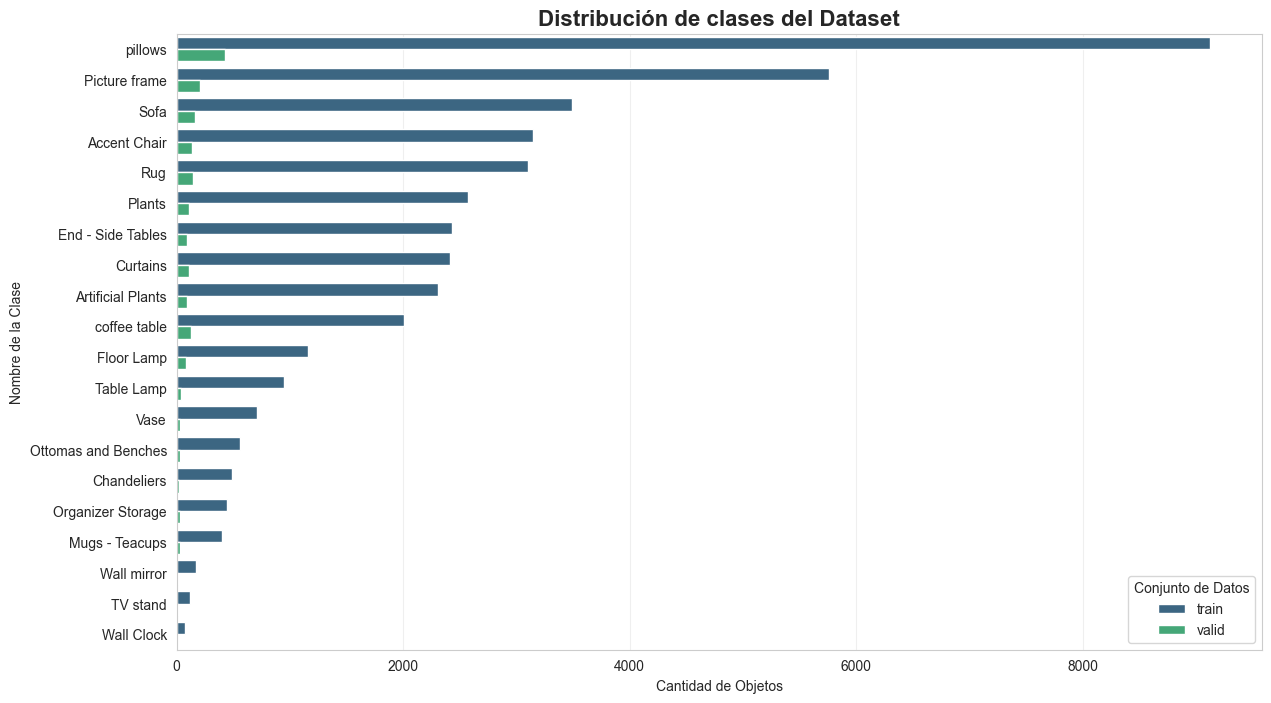

In [9]:
# Gráfica de Barras: Cantidad de objetos por clase
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=df, y='class_name', hue='split', palette='viridis', order=df['class_name'].value_counts().index)

plt.title("Distribución de clases del Dataset", fontsize=16, fontweight='bold')
plt.xlabel("Cantidad de Objetos")
plt.ylabel("Nombre de la Clase")
plt.legend(title="Conjunto de Datos")
plt.grid(axis='x', alpha=0.3)
plt.show()

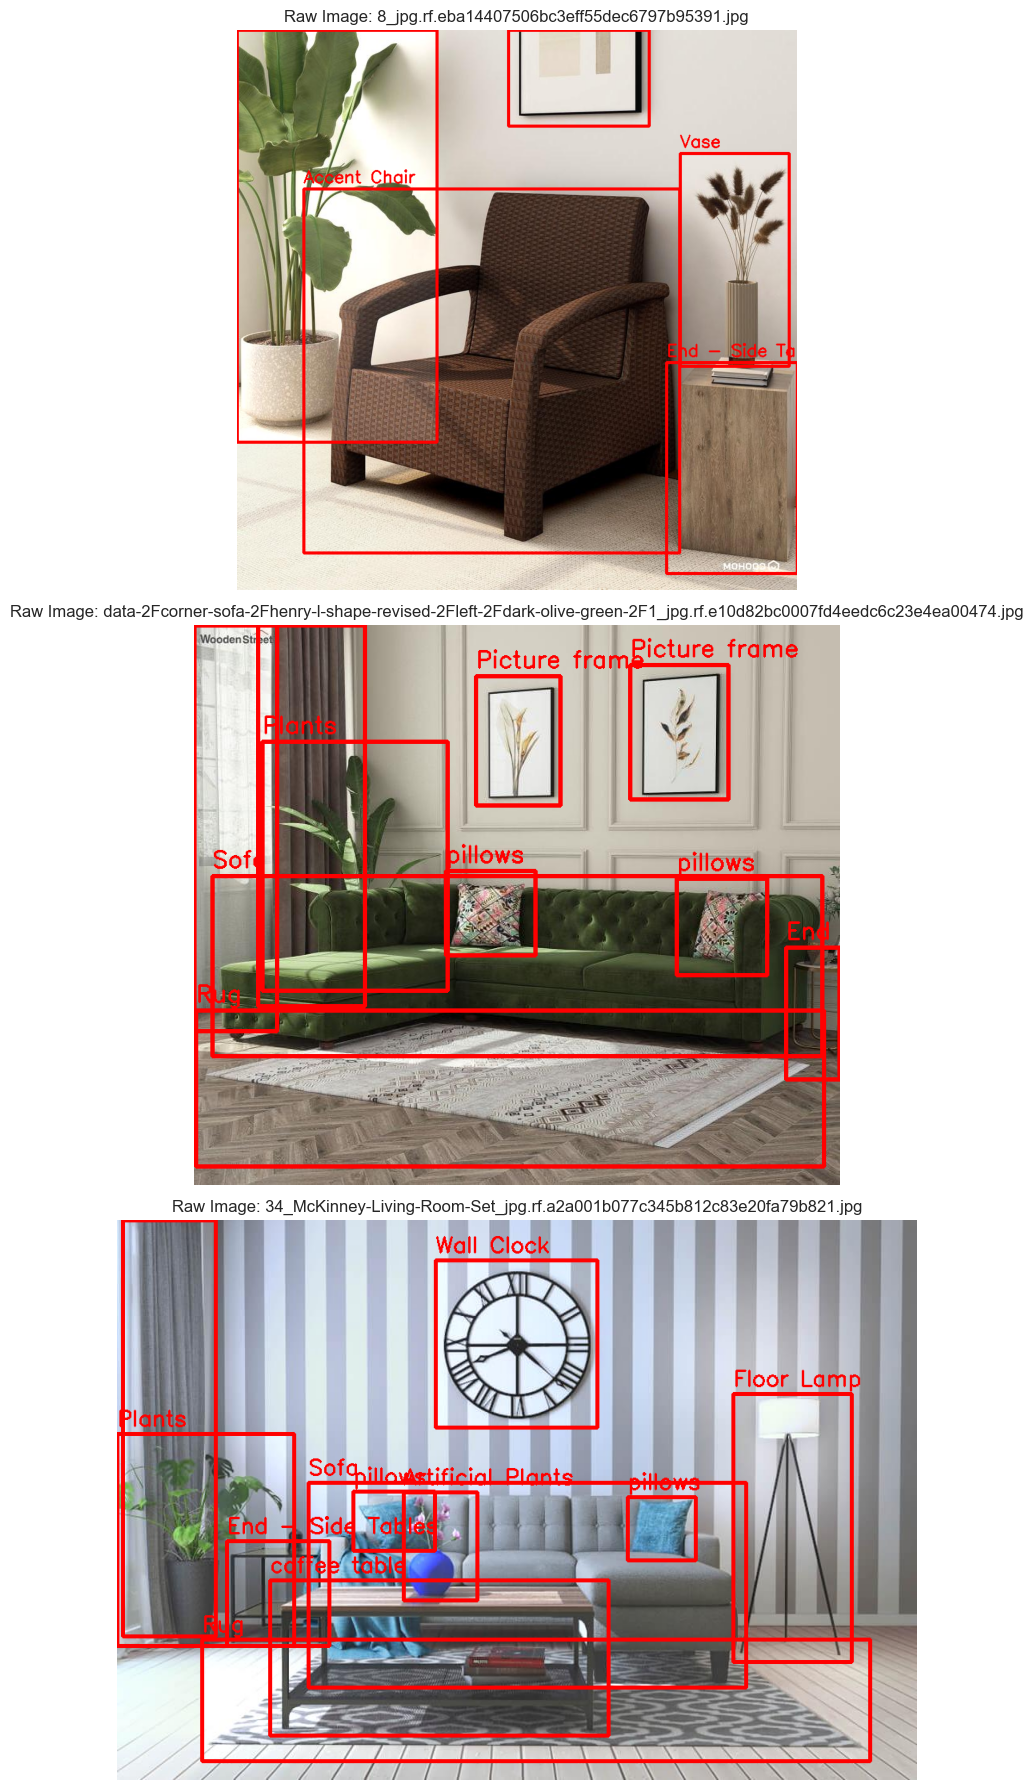

In [10]:
def visualize_raw_samples(num_images=3):
    img_dir = os.path.join(TARGET_DIR, "train", "images")
    lbl_dir = os.path.join(TARGET_DIR, "train", "labels")
    
    images = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
    
    if not images: return

    import random
    samples = random.sample(images, num_images)
    
    plt.figure(figsize=(15, 6*num_images))
    
    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape
        
        # Leemos etiqueta correspondiente
        label_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg", ".txt").replace(".png", ".txt"))
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.split()
                cls_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])
                
                # Nombre original
                cls_name = original_classes[cls_id] if isinstance(original_classes, dict) else original_classes[cls_id]
                
                x1 = int((cx - bw/2) * w_img)
                y1 = int((cy - bh/2) * h_img)
                x2 = int((cx + bw/2) * w_img)
                y2 = int((cy + bh/2) * h_img)
                
                # Dibujamos todo lo que hay (incluido el ruido)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
                cv2.putText(img, cls_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
        plt.subplot(num_images, 1, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Raw Image: {os.path.basename(img_path)}")
    
    plt.tight_layout()
    plt.show()

visualize_raw_samples(3)

# Conclusiones
Tras analizar el dataset 'Living-Room-9', observamos que tenemos un total de 20 clases, en este método solo nos enfocaremos en 3 de ellas ('Sofa', 'Rug' y 'Pillows'). Al observar la distribución de las clases, descubrimos que la clase pillows tiene una gran diferencia en comparación a las otras clases, sin embargo, esta diferencia se debe a que, en un sofá, usualmente se encuentran 2 o más cojines (pillows), por lo que se concluye que la diferencia es tolerable. Debido a que el resto de clases se consideran ruido para el método a desarrollar, las clases restantes serán eliminadas, haciendo que el dataset atraviese un proceso de limpieza para dejar las 3 clases principales.